## 1.4 Loss Penalty

이번 실습에서는 Loss Penalty를 이용해 정규화하는 방법에 대해 알아보고자 합니다. 우선 대부분은 Early Stop 실습과 동일하게 진행해줍니다. 

In [1]:
import math
import random 
import os
import tensorflow as tf
import numpy as np 

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
seed = 2020
random.seed(seed)
np.random.seed(seed=seed)
tf.random.set_random_seed(seed)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape([-1, 28 * 28])
x_test = x_test.reshape([-1, 28 * 28])

m = np.random.randint(0, high=60000, size=1100, dtype=np.int64)
x_train = x_train[m]
y_train = y_train[m]

i = np.arange(1100)
np.random.shuffle(i)
x_train = x_train[i]
y_train = y_train[i]

x_valid = x_train[:100]
y_valid = y_train[:100]

x_train = x_train[100:]
y_train = y_train[100:]

x = tf.placeholder(tf.float32, [None, 28 * 28])
y = tf.placeholder(tf.int32, [None])

n_units = [28 * 28, 512, 512, 10]

weights, biases = [], []
for i, (n_in, n_out) in enumerate(zip(n_units[:-1], n_units[1:])):
    stddev = math.sqrt(2 / n_in) # Kaiming He Initialization
    weight = tf.Variable(tf.random.truncated_normal([n_in, n_out], mean=0, stddev=stddev))
    bias = tf.Variable(tf.zeros([n_out]))
    weights.append(weight)
    biases.append(bias)
    
layer = x 
for i, (weight, bias) in enumerate(zip(weights, biases)):
    layer = tf.matmul(layer, weight) + bias
    if i < len(weights) - 1:
        layer = tf.nn.tanh(layer)        
y_hat = layer

Loss Penalty를 이용한 정규화는 loss 함수를 변화시킴으로써 정규화 효과를 얻는 방식을 말합니다. 우리는 이번 실습에서 가장 자주 쓰이는 loss penalty 중 하나인 L2 penalty(weight decay)를 사용해보고자 합니다. 

#### TODO:L2 penalty term 추가하기

In [2]:
y_hot = tf.one_hot(y, 10)
costs = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_hot, logits=y_hat)
cross_entropy_loss = tf.reduce_mean(costs)

### YOUR CODE HERE
'''
Hint: 다음 함수들이 유용할 수 있습니다
- tf.add_n() -- https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/math/add_n
- tf.reduce_sum() -- https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/math/reduce_sum
- tf.square() -- https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/math/square
'''
# tf.reduce_sum까지의 값은 엄밀히 말하면 스칼라가 들어간 텐서 형태이기 때문에 add_n을 쓰는 게 맞다
regularization_loss = tf.add_n([tf.reduce_sum(tf.square(w)) for w in weights])

### END YOUR CODE

loss = cross_entropy_loss + 0.001 * regularization_loss

다시 다른 부분들은 이전 실습과 동일하게 진행해 줍니다.

In [3]:
accuracy = tf.count_nonzero(
        tf.cast(tf.equal(tf.argmax(y_hot, 1), tf.argmax(y_hat, 1)),
                tf.int64)) / tf.cast(tf.shape(y_hot)[0], tf.int64)

extra_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_ops):
    optimizer = tf.train.AdamOptimizer(1e-3)
    train_op = optimizer.minimize(loss)
    
gpu_options = tf.GPUOptions()
gpu_options.allow_growth = True
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
session.run(tf.global_variables_initializer())

max_valid_epoch_idx = 0
max_valid_accuracy = 0.0
final_test_accuracy = 0.0
weight_values = []
for epoch_idx in range(1, 1000 + 1):
    session.run(
            train_op,
            feed_dict={
                x: x_train,
                y: y_train
            })
    
    if epoch_idx % 10 == 0:
        train_loss_value, train_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_train,
                y: y_train
            })
        
        valid_loss_value, valid_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_valid,
                y: y_valid
            })
            
        test_loss_value, test_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_test,
                y: y_test
            })

        print(epoch_idx, '%.4f' % train_loss_value, '%.4f' % valid_loss_value, '%.4f' % test_loss_value, '%.4f' % train_accuracy_value, '%.4f' % valid_accuracy_value, '%.4f' % test_accuracy_value)
        
        if max_valid_accuracy < valid_accuracy_value:
            max_valid_accuracy = valid_accuracy_value 
            max_valid_epoch_idx = epoch_idx
            final_test_accuracy = test_accuracy_value
            
            weight_values = session.run(weights)
            
    # Early Stop
    if max_valid_epoch_idx + 100 < epoch_idx:
        break
        
print(final_test_accuracy)

10 1.7284 2.0847 2.0082 0.9380 0.8000 0.8355
20 1.4422 1.8881 1.8105 0.9950 0.8400 0.8711
30 1.3113 1.8136 1.7061 1.0000 0.8300 0.8761
40 1.2162 1.7437 1.6198 1.0000 0.8400 0.8773
50 1.1332 1.6681 1.5406 1.0000 0.8400 0.8791
60 1.0578 1.5939 1.4670 1.0000 0.8200 0.8788
70 0.9887 1.5263 1.3995 1.0000 0.8300 0.8788
80 0.9249 1.4626 1.3357 1.0000 0.8300 0.8796
90 0.8657 1.4115 1.2764 1.0000 0.8300 0.8780
100 0.8108 1.3538 1.2220 1.0000 0.8200 0.8789
110 0.7597 1.2966 1.1711 1.0000 0.8100 0.8791
120 0.7121 1.2462 1.1227 1.0000 0.8100 0.8796
0.8711


87.10% -> 87.62% 로 성능이 0.52% 향상한 것을 확인할 수 있었습니다.

이제 최종 모델 파라미터의 각 element의 distribution을 확인해봅시다. 

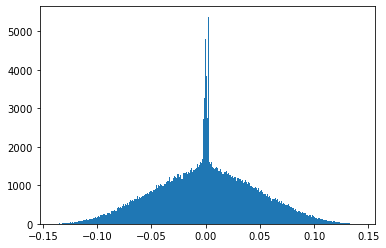

In [4]:
dist = np.concatenate([w.flatten() for w in weight_values], axis=None)

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(dist, bins=1000)
plt.show()

L1과 L2를 동시에 사용하는 정규화 penalty term을 디자인할 수도 있을 것입니다. L1이나 L2를 사용할 때, 각 weight matrix 별로 다른 람다값을 사용하면 더 좋은 성능을 가진 네트워크를 가질 수 있지만, 찾아야 하는 파라미터가 너무 많아져 practical하지 않습니다. 

### 연습 문제

Q1. 람다 값을 변경해보면서 test accuracy 와 weight distribution의 변화를 확인해보세요. 

Q2. L2정규화를 L1으로 바꿔보고, L1에 맞는 람다 값을 찾아보세요. 정규화를 이용해서 성능을 향상시킬 수 있는지, weight distribution에는 어떤 변화가 있는지 확인해봅시다.

Q3. (Optional) L1 정규화를 이용해 각 hidden layer의 적정 hidden unit 갯수를 찾아봅시다. 

주의사항! 코드를 수정한 이후에는 **Kernel > Restart & Run All** 을 통해 네트워크를 처음부터 다시 학습시켜 주세요. 

### 다음 실습

다음 [실습](01_05_hidden_layer_stabilization.ipynb)에서는 Hidden Layer의 statistics을 안정화시키는 방식에 대해서 배워보고자 합니다. 